In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import cm
%run -i pltparams.py

In [2]:
#define functions to add in the data columns we want
def offset_rentBurden(df):
    #for the percRealWageChange calculation, we need the preceding year's rent burden. So making this pd Series which just offsets the rentBuden column by one row
    rB = df["rentBurden"].to_numpy()
    rB = np.concatenate([[0], rB])
    rB = rB[:-1]
    rentBurden_offset = pd.Series(rB)
    return rentBurden_offset

def offset_wages(df):
    wg = df["wages"].to_numpy()
    wg = np.concatenate([[0], wg])
    wg = wg[:-1]
    wages_offset = pd.Series(wg)
    return wages_offset

def add_columns(camp_data, wage_data):
    #pandas not reading formulas in excel correctly so need to do it all here
    for key in campuses:
        df = camp_data[key]
        df["wages"] = wage_data#add wages
        #projecttion for 2024 rent
        df['percRentInc'] =  df.loc[(df['year'] <= 2023)]["2br"].pct_change()
        rent_avg = df['percRentInc'].mean()
        df.at[len(df)-1,'2br'] = (1+rent_avg)*df['2br'].iloc[-2]
        df['percRentInc'] = df["2br"].pct_change()

        df['rentBurden'] = df['2br']/df['wages']
        df['percWageChange'] = df['wages'].pct_change()
        df = df.fillna(0)
        rentBurden_offset = offset_rentBurden(df)
        df['percRealWageChange'] =  df['percWageChange']-  ((rentBurden_offset * df['percRentInc']) + ((1-rentBurden_offset) * df['cpi']  ))
        df.at[0,'percRealWageChange'] = 0
        df['dolRealWageChange'] = (df['percRealWageChange']) * offset_wages(df) * 12

        camp_data[key] = df
    return camp_data


In [3]:
#specify proposal to analyze
prop = 'UAW120822'
# prop = 'UC120222'
#load wage data for a that proposal
fn = "wages_"+prop+".xlsx"
data_wages = pd.read_excel(fn, None)
wages = data_wages["avgStep"]
#load rent data for all campuses
campus_data = pd.read_excel("rent_data.xlsx", None)
campuses = list(campus_data.keys())

In [4]:
data_12mo = add_columns(campus_data.copy(), wages["12mo"].to_numpy())
if prop == "UC120222":
    data_9mo = add_columns(campus_data.copy(), wages["9mo"].to_numpy())

#example of what the dataframes for analysis now looks like
data_12mo["UCR"]

,year,2br,cpi,Unnamed: 3,Unnamed: 4,Unnamed: 5,wages,percRentInc,rentBurden,percWageChange,percRealWageChange,dolRealWageChange
0,2018,626.500000,0.024,0.0,0.0,0.0,2363.670000,0.000000,0.265054,0.00000,0.000000,0.000000
1,2019,667.500000,0.018,0.0,0.0,0.0,2434.580100,0.065443,0.274175,0.03000,-0.000575,-16.307520
2,2020,697.000000,0.012,0.0,0.0,0.0,2507.617500,0.044195,0.277953,0.03000,0.009173,267.989266
3,2021,753.000000,0.047,0.0,0.0,0.0,2582.846030,0.080344,0.291539,0.03000,-0.026268,-790.445910
4,2022,819.500000,0.074,0.0,0.0,0.0,2776.559482,0.088313,0.295149,0.07500,-0.003173,-98.341848
5,2023,960.000000,0.031,0.0,0.0,0.0,3703.070000,0.171446,0.259244,0.33369,0.261238,8704.100086
6,2024,1046.350357,0.024,0.0,0.0,0.0,3962.286667,0.089948,0.264077,0.07000,0.028904,1284.391555


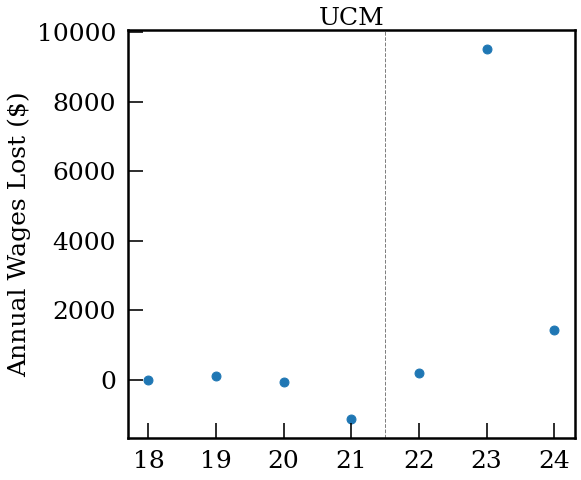

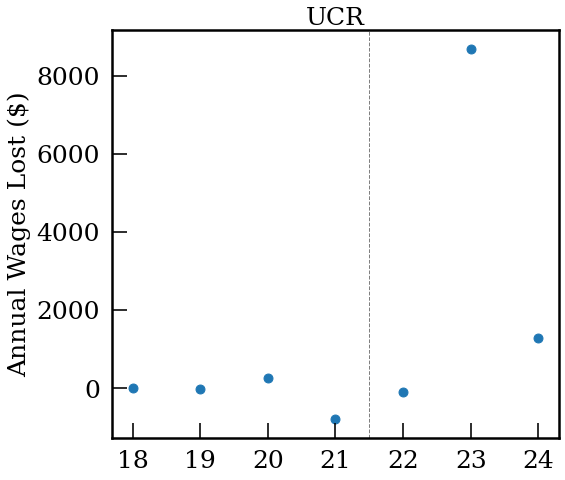

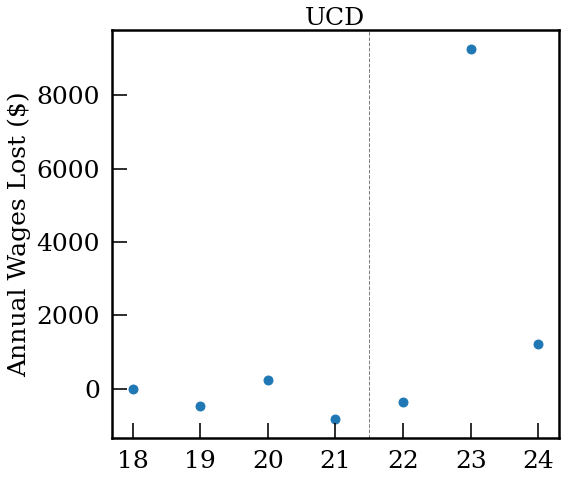

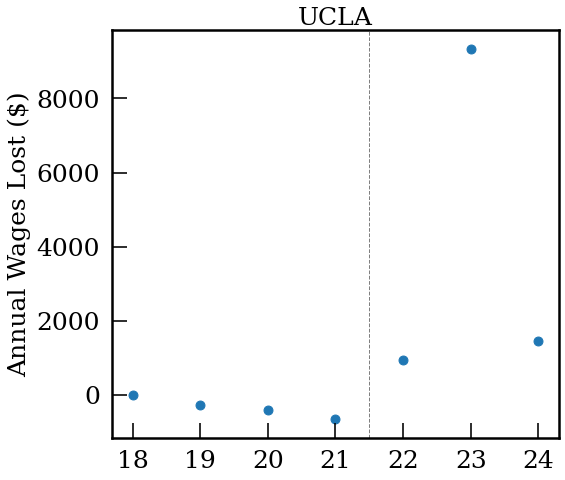

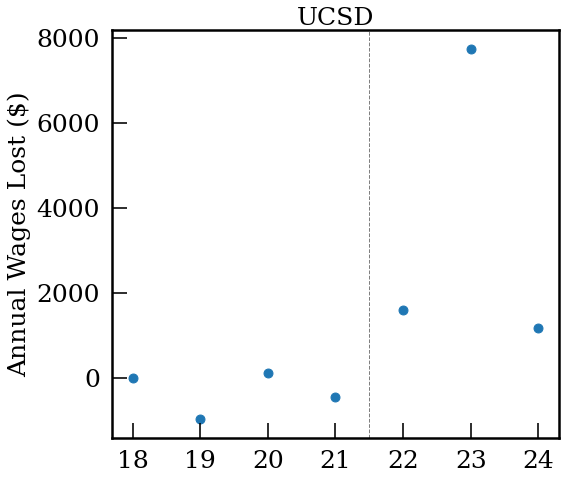

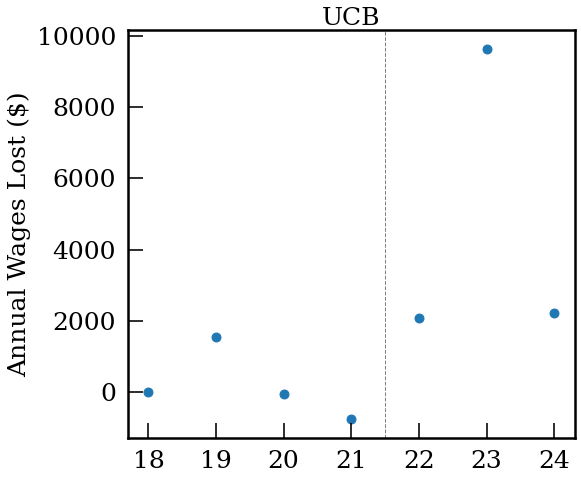

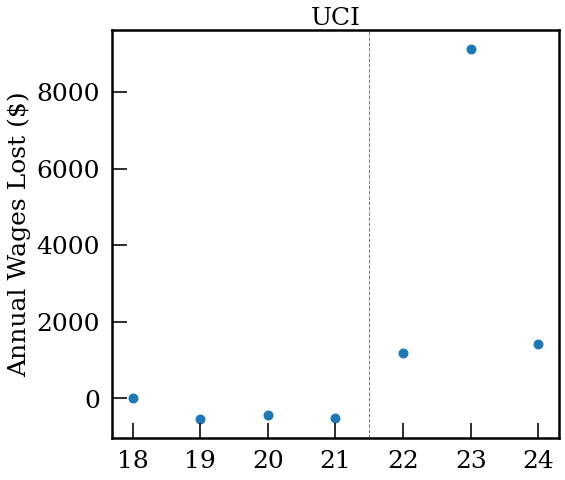

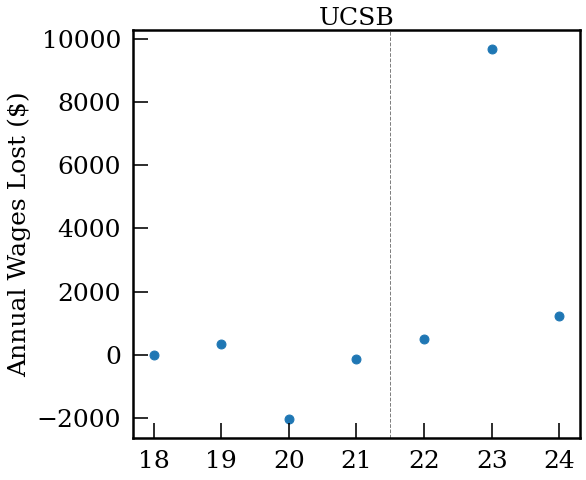

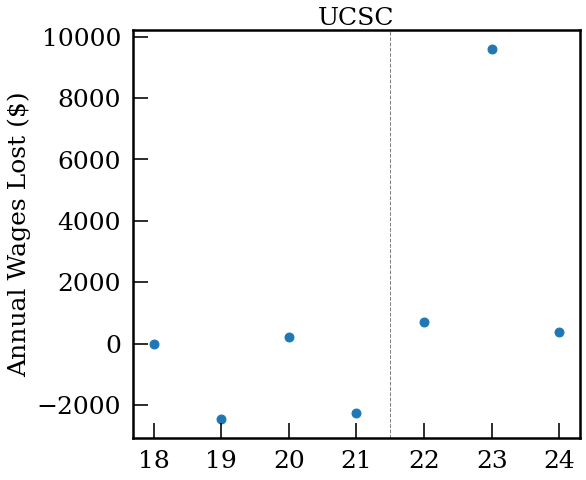

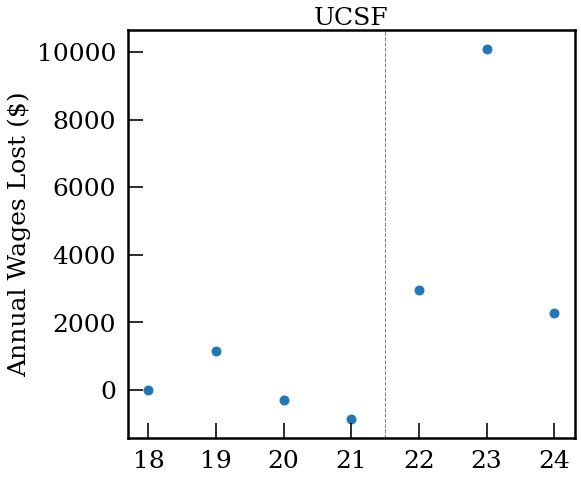

In [5]:
#annual loss in annual wages starting from 2018
for key in campuses: 
    df = data_12mo[key]
    df = df.loc[df["year"]<=2024]
    tix = df['year'].to_numpy()
    tix = np.asarray([(item[-2:]) for item in tix.astype(str)], dtype=int)
    plt.figure()
    plt.scatter(tix, df['dolRealWageChange'],s=80)
    plt.xticks(tix)
    plt.ylabel("Annual Wages Lost ($)")
    plt.axvline(x=21.5, c='gray', ls='--', lw=1)
    plt.title(key)

UCM :          -2.9 %   $ -835
UCR :          -2.1 %   $ -596
UCD :          -4.6 %   $ -1315
UCLA :          -1.7 %   $ -480
UCSD :          0.4 %   $ 118
UCB :          9.4 %   $ 2660
UCI :          -1.3 %   $ -382
UCSB :          -4.8 %   $ -1352
UCSC :          -13.1 %   $ -3709
UCSF :          9.6 %   $ 2730


Text(0.5, -0.05, 'Average across all campuses=  -$316')

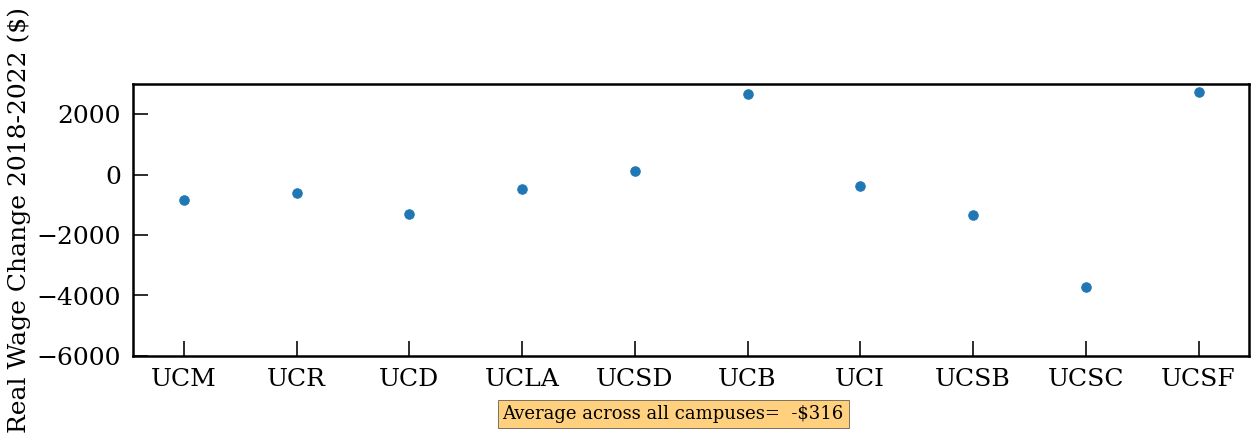

In [6]:
#How much do we lose in real wages for 2022 compared to 2018? 
dolChange_list = []
"""
for key in campuses:
    df = data_12mo[key]
    wage_2018 = float(df["wages"].loc[df["year"]==2018])
    rent_2018 = float(df["2br"].loc[df["year"]==2018])
    rentBurden_2018 = rent_2018/wage_2018
    wage_2022 = float(df["wages"].loc[df["year"]==2022])
    rent_2022 = float(df["2br"].loc[df["year"]==2022])
    wage_percChange = wage_2022/wage_2018 - 1
    rent_percChange = rent_2022/rent_2018 - 1
    cpi_change = (1+df["cpi"].loc[(df["year"]>2018) & (df["year"]<=2022) ]).to_numpy().prod() - 1

    percChangeWrt2018 = wage_percChange -  ((rentBurden_2018 * rent_percChange) + ((1-rentBurden_2018) * cpi_change  ))
    dolChange = percChangeWrt2018 * wage_2018
    print(key,":         ", round(percChangeWrt2018*100, 1), "%   $",  int(dolChange*12),"   " ,cpi_change)
    dolChange_list.append(dolChange*12)
    #wage_2018[0]

"""
#not sure why the above method and the one below are giving (slightly) different results..... need to debug!
for key in campuses:
    df = data_12mo[key]
    df = df.loc[df["year"] <=2022]
    percChangeWrt2018 = (1+df["percRealWageChange"]).to_numpy().prod() - 1
    dolChange = percChangeWrt2018*df["wages"].iloc[0]
    dolChange_list.append(dolChange*12)
    print(key,":         ", round(percChangeWrt2018*100, 1), "%   $",  int(dolChange*12))

plt.figure(figsize=(20,5))
plt.scatter(campuses, dolChange_list, s=90)
plt.ylim([-6000,3000])
plt.ylabel("Real Wage Change 2018-2022 ($)")
plt.figtext(0.5, -0.05, "Average across all campuses=  -$" + str(-1*int(np.mean(dolChange_list)) ), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


In [7]:
#cumulative losses for 2018-2022 (inclusive)
cum_losses_list =[]
end_year = 2024
for key in campuses:
    df = data_12mo[key]
    df = df.loc[df["year"] <=end_year]
    cum_loss = df["dolRealWageChange"].sum()
    cum_losses_list.append(cum_loss)
    print(key,":         $", round(cum_loss, 1))

UCM :         $ 10091.9
UCR :         $ 9351.4
UCD :         $ 9073.4
UCLA :         $ 10368.3
UCSD :         $ 9219.5
UCB :         $ 14656.1
UCI :         $ 10259.0
UCSB :         $ 9584.3
UCSC :         $ 6170.0
UCSF :         $ 15339.9


In [8]:
#inflation and rent adjusted % increase in income
for y_i in [2018,2021]:
    print("relative to {}".format(y_i))
    print("------------------")
    cont_change_list = []
    for key in campuses:
        df = data_12mo[key]
        df = df.loc[(df['year'] > y_i)]

        temp_array = 1+df["percRealWageChange"].to_numpy()
        cont_change = int((np.prod(temp_array)-1) * 100)
        cont_change_list.append(cont_change)

        print(key,":",cont_change,"%" )
    print('average :',np.mean(cont_change_list),'%\n')

relative to 2018
------------------
UCM : 28 %
UCR : 27 %
UCD : 25 %
UCLA : 30 %
UCSD : 27 %
UCB : 48 %
UCI : 29 %
UCSB : 26 %
UCSC : 12 %
UCSF : 50 %
average : 30.2 %

relative to 2021
------------------
UCM : 33 %
UCR : 29 %
UCD : 29 %
UCLA : 36 %
UCSD : 33 %
UCB : 44 %
UCI : 36 %
UCSB : 34 %
UCSC : 32 %
UCSF : 50 %
average : 35.6 %



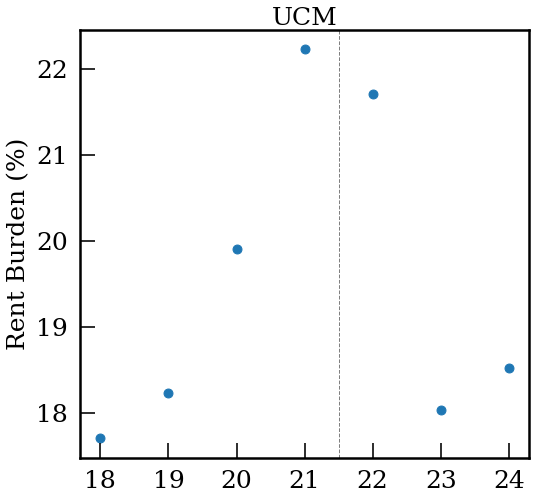

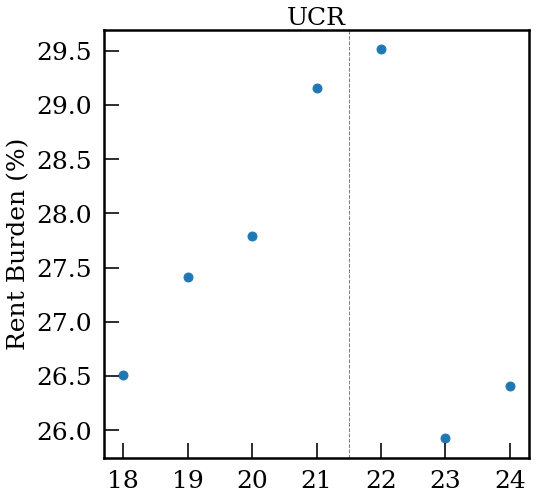

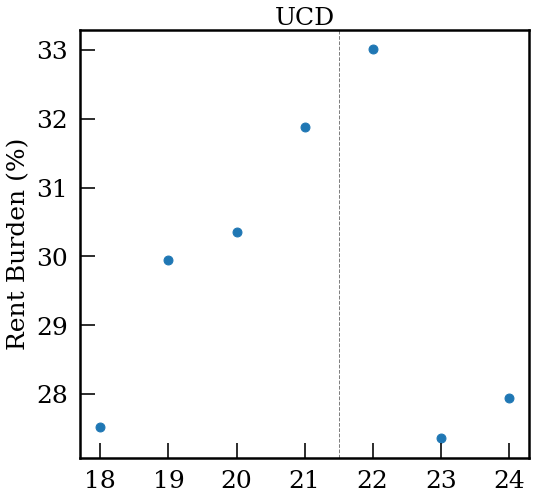

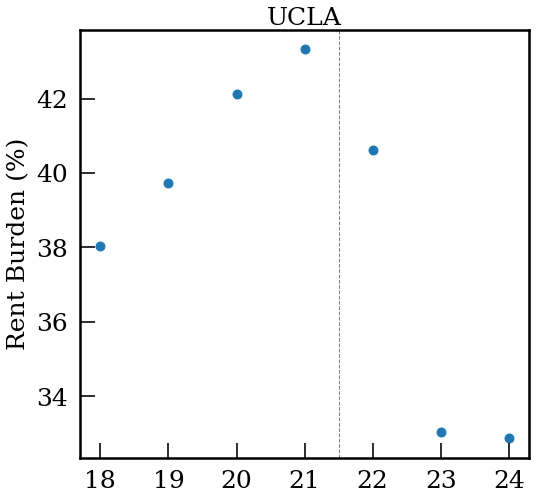

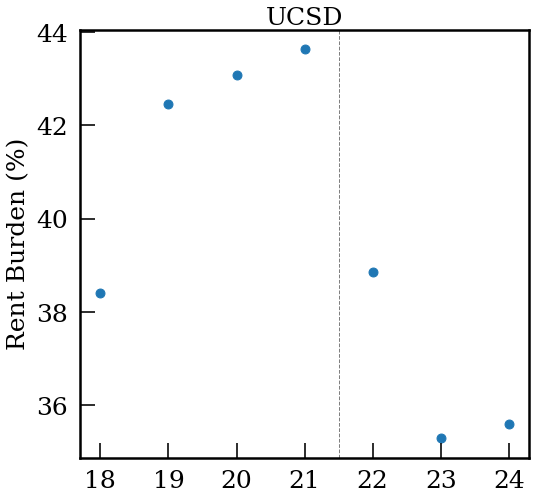

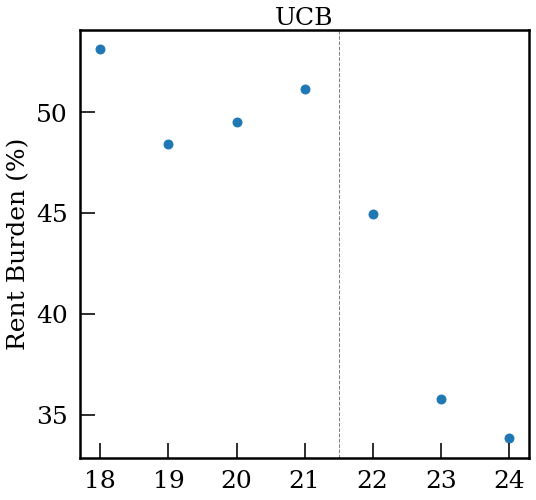

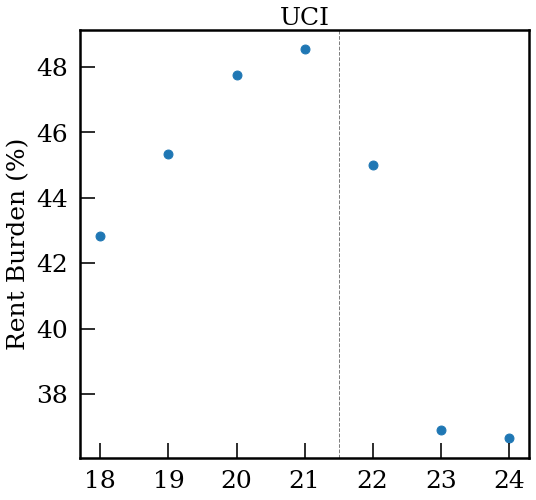

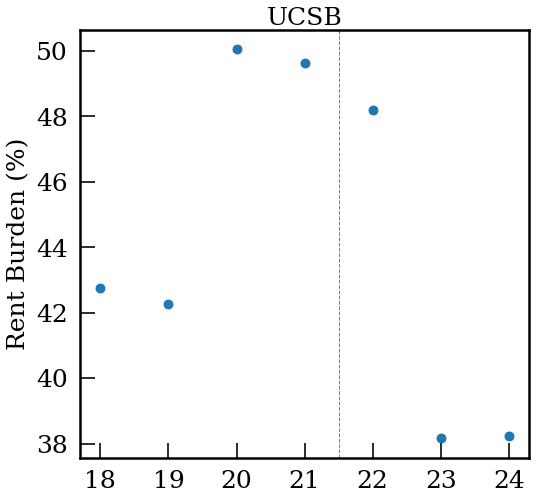

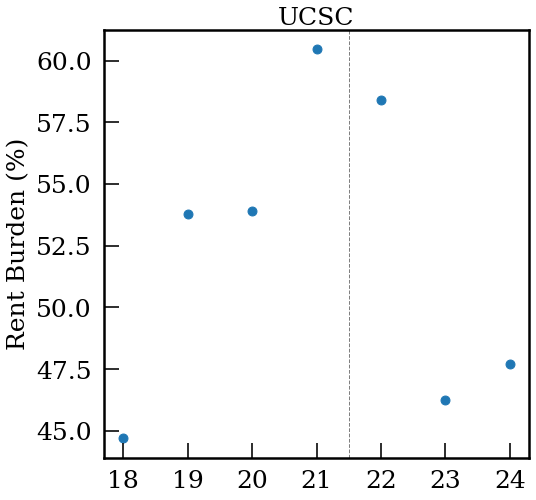

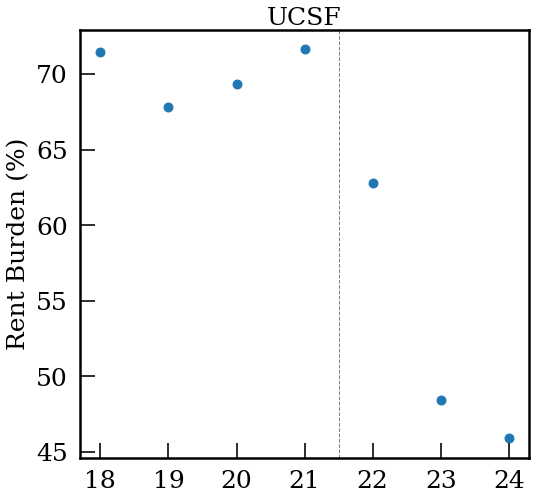

In [9]:
#rent burden over time, each campus plotted separately
for key in campuses:
    df_12mo = data_12mo[key]
    if prop == "UC120222":
        df_9mo = data_9mo[key]
    tix = df_12mo['year'].to_numpy()
    tix = np.asarray([(item[-2:]) for item in tix.astype(str)], dtype=int)
    plt.figure()
    plt.scatter(tix, df_12mo['rentBurden']*100,s=80, label = "12 month pay")
    if prop == "UC120222":
        plt.scatter(tix, df_9mo['rentBurden']*100,s=80, label = "9 month pay")
    plt.xticks(tix)
    plt.ylabel("Rent Burden (%)")
    plt.axvline(x=21.5, c='gray', ls='--', lw=1)
    plt.title(key)
    plt.tight_layout()
#     plt.savefig("./RB_{}.png".format(key))
#     plt.legend(frameon=True)

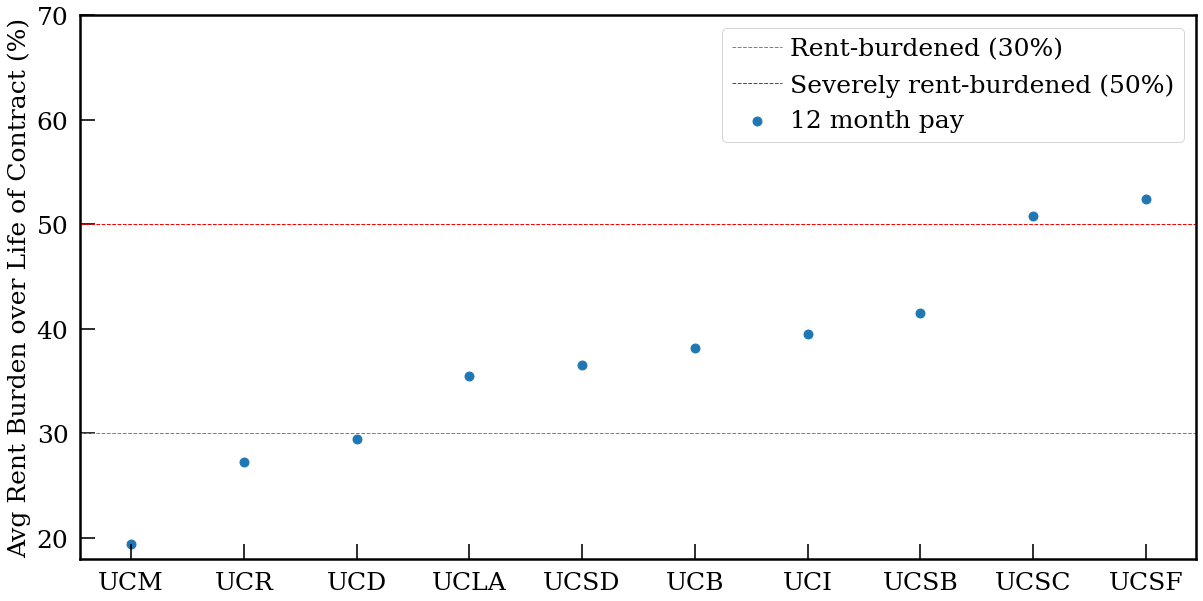

In [10]:
def timeseries_rent_burden(my_data):
    RB =[]
    yr = 2022
    for t in range(3):
        RB_t = []
        for key in campuses:
            df = my_data[key]
            df = df.loc[(df['year'] == yr)] #get data only at given year
            RB_t.append( df["rentBurden"].values[0]*100 )
        RB.append(RB_t)
        yr += 1
    return np.array(RB)

#whether to plot the average rent-burdens or timeseries of data
plot_timeseries = False

RB_12mo = timeseries_rent_burden(data_12mo)
avgRB_12mo = np.mean(RB_12mo, axis=0)
if prop == "UC120222":
    RB_9mo = timeseries_rent_burden(data_9mo)
    avgRB_9mo = np.mean(RB_9mo, axis=0)

plt.figure(figsize=(20,10))
if plot_timeseries:
    cmap_12mo = cm.get_cmap('Blues', 12)
    cmap_9mo = cm.get_cmap('Oranges', 12)
    for i,t in enumerate(range(3)):
        plt.scatter(campuses, RB_12mo[t], s=80, c=cmap_12mo((i+1)/3), label="12 month pay {}".format(2022+t))
        if prop == "UC120222":
            plt.scatter(campuses, RB_9mo[t], s=80, c=cmap_9mo((i+1)/3), label="9 month pay {}".format(2022+t))
        plt.ylabel("Rent Burden (%)")
else:
    plt.scatter(campuses, avgRB_12mo, s=80, label="12 month pay")
    if prop == "UC120222":
        plt.scatter(campuses, avgRB_9mo, s=80, label="9 month pay")
    plt.ylabel("Avg Rent Burden over Life of Contract (%)")

plt.axhline(y=30,c='gray', ls='--', lw=1, label = "Rent-burdened (30%)")
plt.axhline(y=50,c='red', ls='--', lw=1, label = "Severely rent-burdened (50%)")
plt.ylim([18,70])
plt.legend(frameon=True)
# plt.tight_layout()
# plt.savefig("./RB.png")

The standard deviation in rent burden change is 4.219498448276359
The range of rent burden change is 13.7598744813596


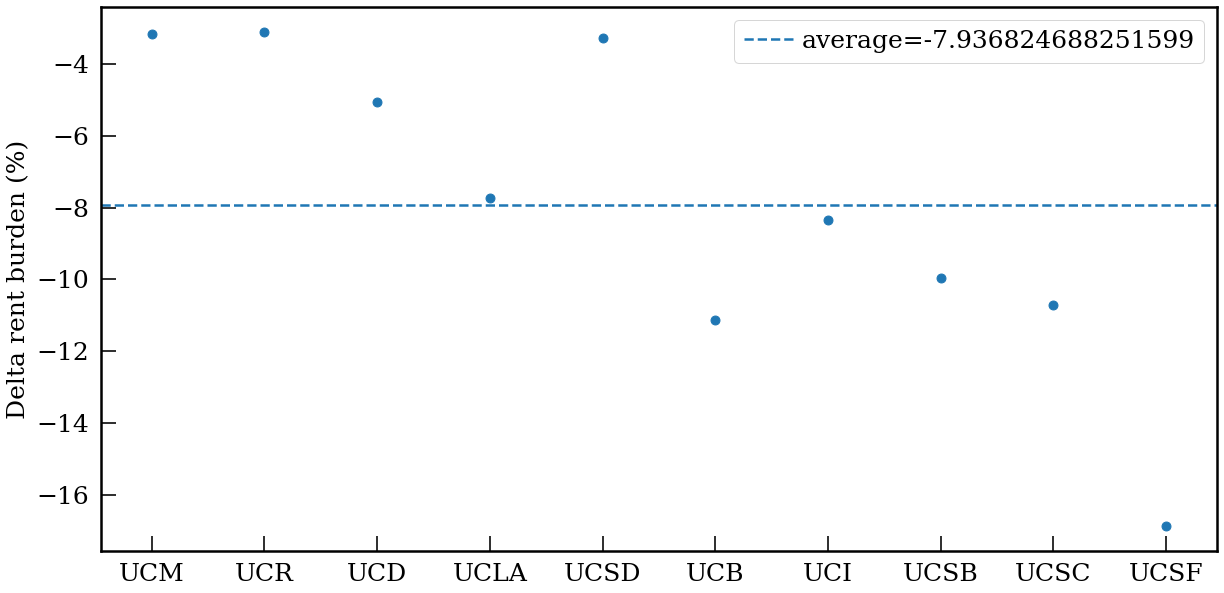

In [11]:
#change in rent burden over contract duration 
del_RB = np.array(RB_12mo[-1]) - np.array(RB_12mo[0])
plt.figure(figsize=(20,10))
plt.scatter(campuses, del_RB, s=80)
plt.axhline(np.mean(del_RB), label='average={}'.format(np.mean(del_RB)), ls='--')
plt.ylabel("Delta rent burden (%)")
plt.legend(frameon=True)
print("The standard deviation in rent burden change is {}".format(np.std(del_RB)))
print("The range of rent burden change is {}".format(max(del_RB)-min(del_RB)))

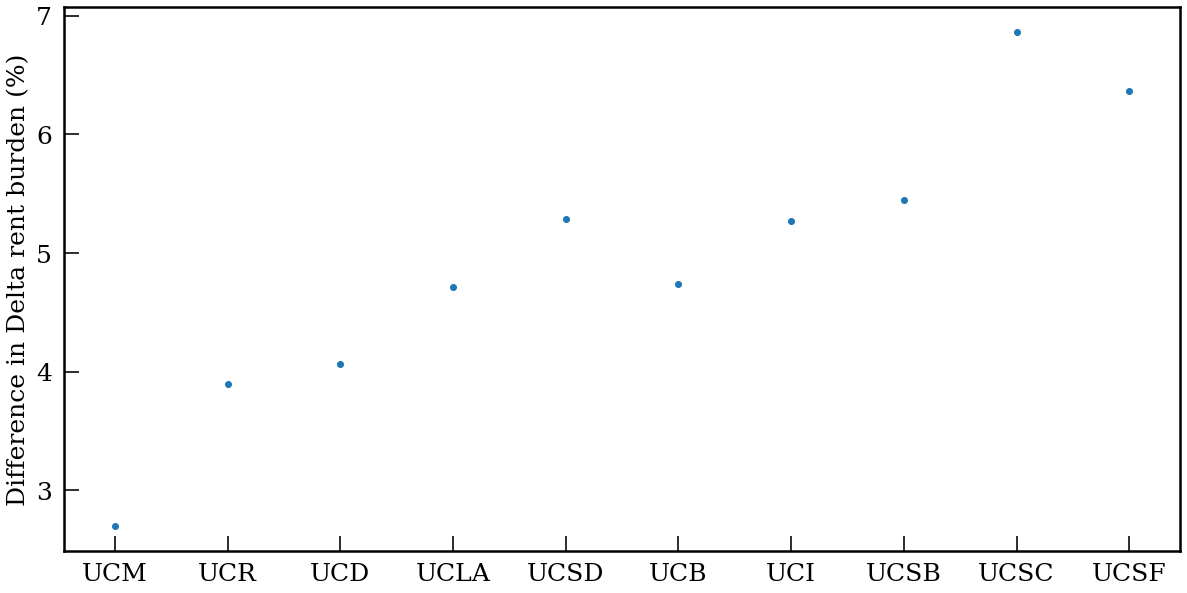

In [12]:
#difference in Delta rent burden between UC 12/02 and another proposal
del_RB_UCprop = np.array([ -0.4767653 ,   0.7933604 ,  -1.00196351,  -3.02056919,
         2.02496995,  -6.40018988,  -3.07092568,  -4.51779004,
        -3.84420035, -10.50011205])
plt.figure(figsize=(20,10))
plt.ylabel("Difference in Delta rent burden (%)")
plt.scatter(campuses, del_RB_UCprop - del_RB)